<a href="https://colab.research.google.com/github/m-d-nabeel/mnist-dataset/blob/main/next_word_predictor_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# !kaggle datasets download -d ronikdedhia/next-word-prediction
# !unzip -q next-word-prediction.zip
# !mv 1661-0.txt next-word-dataset.txt
# !rm -rf 166* *.zip

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
text_dataset = """"""
with open("next-word-dataset.txt") as f:
  text_dataset = f.read()

In [10]:
tokenizer = Tokenizer()

In [11]:
tokenizer.fit_on_texts([text_dataset])

In [12]:
unique_words = len(tokenizer.word_counts)
print(unique_words)

8931


In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
sentences = nltk.sent_tokenize(text_dataset)
sentences = [sentence.replace('\n', ' ') for sentence in sentences]

In [72]:
sentences[205]

'I suppose that you have been watching the habits, and perhaps the house, of Miss Irene Adler.”  “Quite so; but the sequel was rather unusual.'

In [16]:
seqs_sentences = tokenizer.texts_to_sequences(sentences)

In [17]:
seqs_sentences[20]

[11, 135, 428, 4, 1, 4805, 4806, 331, 18, 5, 4807, 2, 5, 1932]

In [18]:
tokenizer.texts_to_sequences(['He never spoke of the softer passions, save with a gibe and a sneer.'])[0]

[11, 135, 428, 4, 1, 4805, 4806, 331, 18, 5, 4807, 2, 5, 1932]

In [19]:
# Sample data

# count = 0
# for sequence in seqs_sentences:
#   print(sequence)
#   count += 1
#   if count == 5:
#     break

In [20]:
training_sequences = []

for seq_sentence in seqs_sentences:
  for i in range(1, len(seq_sentence)):
    training_sequences.append(seq_sentence[:i + 1])

In [21]:
for i in range(5):
  print(training_sequences[i])

[4789, 145]
[4789, 145, 4790]
[4789, 145, 4790, 1]
[4789, 145, 4790, 1, 1020]
[4789, 145, 4790, 1, 1020, 4]


In [22]:
max_word_len = max([len(x) for x in training_sequences])
print(max_word_len)

251


In [23]:
padded_training_sequences = pad_sequences(sequences=training_sequences, maxlen=max_word_len, padding="pre")

In [24]:
X = padded_training_sequences[:, :-1]
y = padded_training_sequences[:, -1]

In [25]:
X

array([[   0,    0,    0, ...,    0,    0, 4789],
       [   0,    0,    0, ...,    0, 4789,  145],
       [   0,    0,    0, ..., 4789,  145, 4790],
       ...,
       [   0,    0,    0, ..., 8931,    3,  360],
       [   0,    0,    0, ...,    3,  360,   83],
       [   0,    0,    0, ...,  360,   83,  358]], dtype=int32)

In [26]:
y

array([ 145, 4790,    1, ...,   83,  358, 1673], dtype=int32)

In [27]:
from keras.utils import to_categorical

y = to_categorical(y, num_classes=unique_words+1)

In [28]:
print(X.shape)
print(y.shape)

(106419, 250)
(106419, 8932)


## Model Building

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [30]:
model = Sequential()

# number of unique words as input as well as output
# i.e. why Embedding and Dense have 8932 units

model.add(Embedding(input_dim=8932, output_dim=100, input_length=max_word_len-1))

# 500 dimension input to LSTM layer
# here units specify ft(forget gate) ht(new hidden state) and ct(new cell state)
model.add(LSTM(units=150))

model.add(Dense(units=8932, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          893200    
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 8932)              1348732   
                                                                 
Total params: 2392532 (9.13 MB)
Trainable params: 2392532 (9.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


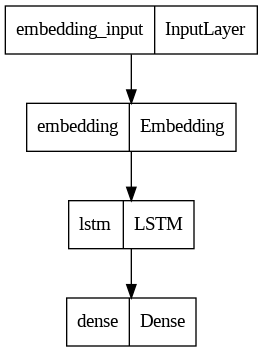

In [39]:
from keras.utils import plot_model

plot_model(model)

In [32]:
model.fit(X, y, epochs=50)

Epoch 1/50
3326/3326 [==============================] - 93s 27ms/step - loss: 6.2938 - accuracy: 0.0835
Epoch 2/50
3326/3326 [==============================] - 54s 16ms/step - loss: 5.4590 - accuracy: 0.1371
Epoch 3/50
3326/3326 [==============================] - 54s 16ms/step - loss: 5.0229 - accuracy: 0.1619
Epoch 4/50
3326/3326 [==============================] - 52s 16ms/step - loss: 4.6571 - accuracy: 0.1821
Epoch 5/50
3326/3326 [==============================] - 51s 15ms/step - loss: 4.3269 - accuracy: 0.2009
Epoch 6/50
3326/3326 [==============================] - 52s 16ms/step - loss: 4.0214 - accuracy: 0.2232
Epoch 7/50
3326/3326 [==============================] - 51s 15ms/step - loss: 3.7374 - accuracy: 0.2541
Epoch 8/50
3326/3326 [==============================] - 50s 15ms/step - loss: 3.4736 - accuracy: 0.2871
Epoch 9/50
3326/3326 [==============================] - 51s 15ms/step - loss: 3.2275 - accuracy: 0.3227
Epoch 10/50
3326/3326 [==============================] - 51s 15m

In [58]:
import numpy as np

def predict(text):
    # Tokenize the text
    tokenized_text = tokenizer.texts_to_sequences([text])

    # Since texts_to_sequences returns a list of lists, get the inner list
    tokenized_text = tokenized_text[0]

    # Pad the tokenized text to the specified max length
    padded_token_text = pad_sequences([tokenized_text], maxlen=max_word_len - 1, padding="pre")

    # Ensure the padded_token_text is of shape (1, max_word_len) which the model expects
    # Model expects a 2D array, not a 3D array, so ensure we have the correct dimensions
    padded_token_text = np.array(padded_token_text)  # Convert to a NumPy array if not already

    # Predict the next word's index
    prediction = model.predict(padded_token_text)
    idx = np.argmax(prediction)
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return "<NIL>"

In [34]:
predict("Sherlock")

1/1 [==============================] - 0s 382ms/step
holmes


In [47]:
def predict_tops(text):
    tokenized_text = tokenizer.texts_to_sequences([text])
    tokenized_text = tokenized_text[0]
    padded_token_text = pad_sequences([tokenized_text], maxlen=max_word_len, padding="pre")
    padded_token_text = np.array(padded_token_text)
    predictions = model.predict(padded_token_text)
    predictions = predictions.flatten()
    top_two_indices = np.argsort(predictions)[-3:][::-1]
    index_to_word = {index: word for word, index in tokenizer.word_index.items()}
    top_two_words = [index_to_word[idx] for idx in top_two_indices if idx in index_to_word]
    print("Top 3 predictions :")
    for word in top_two_words:
        print(f"{text} [{word}]")

In [48]:
predict_tops("He never spoke of the")

1/1 [==============================] - 0s 29ms/step
Top 3 predictions :
He never spoke of the [softer]
He never spoke of the [alarm]
He never spoke of the [estate]


In [49]:
predict_tops("He never spoke of the softer")

1/1 [==============================] - 0s 21ms/step
Top 3 predictions :
He never spoke of the softer [passions]
He never spoke of the softer [what]
He never spoke of the softer [above]


In [38]:
model.save("next_word_predictor.h5")
model.save("next_word_predictor.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
predict_tops("it is simplicity")

1/1 [==============================] - 0s 22ms/step
Top 3 predictions :
it is simplicity [itself]
it is simplicity [sherlock]
it is simplicity [”]


In [53]:
predict_tops("it is simplicity itself")

1/1 [==============================] - 0s 19ms/step
Top 3 predictions :
it is simplicity itself [”]
it is simplicity itself [i]
it is simplicity itself [that]


In [54]:
predict_tops("it is simplicity itself that")

1/1 [==============================] - 0s 22ms/step
Top 3 predictions :
it is simplicity itself that [i]
it is simplicity itself that [we]
it is simplicity itself that [he]


In [55]:
predict_tops("my eyes")

1/1 [==============================] - 0s 21ms/step
Top 3 predictions :
my eyes [were]
my eyes [twinkled]
my eyes [caught]


In [57]:
predict_tops("my eyes tell me that on the inside")

1/1 [==============================] - 0s 20ms/step
Top 3 predictions :
my eyes tell me that on the inside [of]
my eyes tell me that on the inside [which]
my eyes tell me that on the inside [side]


In [73]:
example = "I suppose that you have been watching"
for i in range(20):
  example = f"{example} {predict(example)}"

print(example)

1/1 [==============================] - 0s 19ms/step
I suppose that you have been watching the habits and perhaps the house of miss irene adler certainly has a most easy man material person ” said
